# Generative Model

Instead of classifying/predicting a value, we learn some underlying __probability distribution__ that governs what we see in the training data. Then, we can __sample__ from this distribution to __produce data that statistically "resembles" the original__.

Non-deterministic outputs!

# Generative Model 1: GANs

Two neural networks "compete" with each other. Generator creates images. Discriminator determines whether images are fake or real.

- Training the Discriminator: Training data is a giant dataset of real vs. fake images. Thus the loss optimizes for maximizing the probability of real data being classified "real", and fake data being classified "fake".

- Training the Generator: Loss is minimized when I successfully fool the discriminator.

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

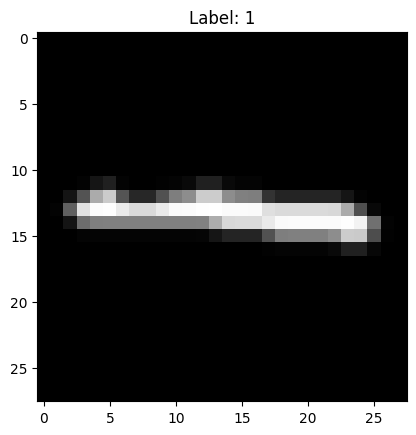

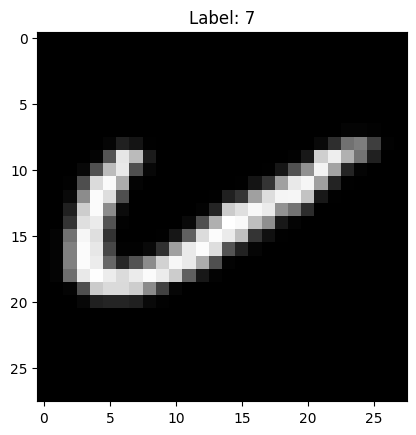

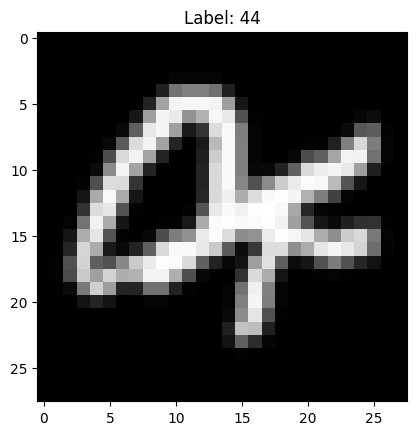

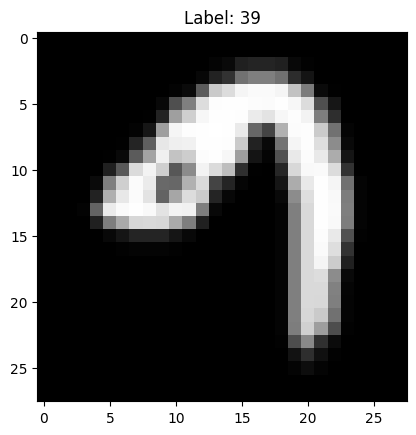

In [23]:
# LOAD IN DATASET
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors
])
data = torchvision.datasets.EMNIST(root=".", split="bymerge", download=False, transform=transform)    # NEED TRANSFORM FIELD!!

# Split into 80-20 train and test sets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

batch_size = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Loading in features and labels
train_features, train_labels = next(iter(train_loader))

for i in range(batch_size):
    img = train_features[i].squeeze()
    label = train_labels[i]
    plt.figure()
    plt.imshow(img.numpy(), cmap="gray")
    plt.title(f"Label: {label}")
    plt.show()

In [36]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)     # only 1 input channel
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        
        return torch.sigmoid(x), loss

In [43]:
d = Discriminator()


# GET A SINGLE BATCH:
# train_features  -  (B, C, H, W)
# train_labels    -  (B)
train_features, train_labels = next(iter(train_loader))
predicted = d.forward(train_features)
print(predicted)
    

tensor([[0.5551],
        [0.5155],
        [0.5422],
        [0.5216]], grad_fn=<SigmoidBackward0>)


In [ ]:
optimizer = torch.optim.AdamW(d.parameters(), lr=1e-3)

for epoch in range(10000):
    xb, yb = get_batch('train')
    logits, loss = my_model.forward(xb, yb)
    
    optimizer.zero_grad(set_to_none = True)
    loss.backward()
    optimizer.step()
    
    if epoch % 2000 == 0:
        print(f"epoch {epoch}: loss is {loss}")

# Generative Model 2: DDPMs

Add noise to the image. Neural net takes in some (noised) image and removes the noise.

GAN = High quality + fast sampling
VAE = fast sampling + Mode diversity
DDM = high quality + mode diversity

VAE compresses, then samples and decodes
GANs have high quality outputs but are hard to train: 2 networks == vanishing gradient problem.

Diffusion is much slower in sampling

# noise scheduler + neural + timestep encoding
